<a href="https://colab.research.google.com/github/serkansokmen/ml-workspace/blob/master/LSTM_TPU_Shakespeare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying questions without obvious keywords

### Import libraries

In [0]:
# Import libraries
import tensorflow as tf
import pandas as pd
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Authenticate to our cloud account

In [2]:
from google.colab import auth
auth.authenticate_user()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Download CSV

In [3]:
filename = 'SO_ml_tags_avocado_188k_v2'
filepath = f'https://storage.googleapis.com/cloudml-demo-lcm/{filename}.csv'

!wget {filepath}

--2019-09-08 16:50:53--  https://storage.googleapis.com/cloudml-demo-lcm/SO_ml_tags_avocado_188k_v2.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290120060 (277M) [application/octet-stream]
Saving to: ‘SO_ml_tags_avocado_188k_v2.csv’

SO_ml_tags_avocado_ 100%[===================>] 276.68M   162MB/s    in 1.7s    

2019-09-08 16:50:55 (162 MB/s) - ‘SO_ml_tags_avocado_188k_v2.csv’ saved [290120060/290120060]



In [4]:
data = pd.read_csv(f'{filename}.csv', names=['tags', 'original_tags', 'text'], header=0)
data = data.drop(columns=['original_tags'])
data = data.dropna()

data = shuffle(data, random_state=22)
data.head()

,tags,text
182914,"tensorflow,keras",avocado image captioning model not compiling b...
48361,pandas,return excel file from avocado with flask in f...
181447,"tensorflow,keras",validating with generator (avocado) i'm trying...
66307,pandas,avocado multiindex dataframe selecting data gi...
11283,pandas,get rightmost non-zero value position for each...


### Encode tags to multi-hot

In [5]:
tags_split = [tags.split(',') for tags in data['tags'].values]
print(tags_split, '\n')

[['tensorflow', 'keras'], ['pandas'], ['tensorflow', 'keras'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['pandas'], ['matplotlib'], ['matplotlib'], ['tensorflow'], ['matplotlib'], ['scikitlearn'], ['scikitlearn'], ['scikitlearn'], ['pandas'], ['keras'], ['pandas'], ['matplotlib'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['keras'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['tensorflow'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['matplotlib'], ['matplotlib'], ['matplotlib'], ['pandas'], ['tensorflow'], ['keras'], ['pandas'], ['matplotlib'], ['pandas'], ['scikitlearn'], ['pandas'], ['pandas'], ['matplotlib', 'scikitlearn'], ['tensorflow', 'keras'], ['pandas', 'scikitlearn'], ['pandas'], ['tensorflow'], ['pandas', 'scikitlearn'], ['scikitlearn'], ['pandas'], ['pandas'], ['pandas'], ['pandas'], ['tensorflow'], ['tensorflow'], ['pandas'], ['scikitlearn'], ['scikitlearn'], ['tensorflow'], ['pandas'], ['tens

In [6]:
tag_encoder = MultiLabelBinarizer()
tags_encoded = tag_encoder.fit_transform(tags_split)
num_tags = len(tags_encoded[0])
print(data['text'].values[0])
print(tag_encoder.classes_)
print(tags_encoded[0])

avocado image captioning model not compiling because of concatenate layer when mask_zero=true in a previous layer i am new to avocado and i am trying to implement a model for an image captioning project.   i am trying to reproduce the model from image captioning pre-inject architecture (the picture is taken from this paper: where to put the image in an image captioning generator) (but with a minor difference: generating a word at each time step instead of only generating a single word at the end), in which the inputs for the lstm at the first time step are the embedded cnn features. the lstm should support variable input length and in order to do this i padded all the sequences with zeros so that all of them have maxlen time steps.  the code for the model i have right now is the following:    def get_model(model_name, batch_size, maxlen, voc_size, embed_size,          cnn_feats_size, dropout_rate):      # create input layer for the cnn features     cnn_feats_input = input(shape=(cnn_fe

# 80/20 train test split

In [7]:
train_size = int(len(data) * .8)
print(f'Train size: {train_size}')
print(f'Test size: {len(data) - train_size}')

Train size: 150559
Test size: 37640


### Split labels into train and test

In [0]:
train_tags = tags_encoded[:train_size]
test_tags = tags_encoded[train_size:]

# Create tokenizer class

In [9]:
%%writefile preprocess.py

from tensorflow.keras.preprocessing import text

class TextPreprocessor(object):
  def __init__(self, vocab_size):
    self._vocab_size = vocab_size
    self._tokenizer = None
    
  def create_tokenizer(self, text_list):
    tokenizer = text.Tokenizer(num_words=self._vocab_size)
    tokenizer.fit_on_texts(text_list)
    self._tokenizer = tokenizer
  
  def transform_text(self, text_list):
    text_matrix = self._tokenizer.texts_to_matrix(text_list)
    return text_matrix

Writing preprocess.py


In [0]:
# Create vocab from training corpus
from preprocess import TextPreprocessor

VOCAB_SIZE = 400 # This is a hyperparameter, try out different values for your dataset

train_qs = data['text'].values[:train_size]
test_qs = data['text'].values[train_size:]

processor = TextPreprocessor(VOCAB_SIZE)
processor.create_tokenizer(train_qs)

body_train = processor.transform_text(train_qs)
body_test = processor.transform_text(test_qs)

In [11]:
print(len(body_train[0]))
print(body_train[0])

400
[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0

# Build the model

## Save the tokenizer state

In [0]:
import pickle

with open('./processor_state.pkl', 'wb') as f:
  pickle.dump(processor, f)

## Create the model

In [0]:
def create_model(vocab_size, num_tags):
  model = Sequential()
  model.add(Dense(50, input_shape=(vocab_size,), activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(num_tags, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  
  return model

In [21]:
model = create_model(VOCAB_SIZE, num_tags)
model.summary()

INFO:tensorflow:Initializing the TPU system.
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Querying Tensorflow master (grpc://10.115.146.90:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6313843679144683677)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 7146795612552760886)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 4101222470845620111)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2045066758410007747)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 1717

### Train

In [22]:
model.fit(body_train, 
          train_tags, 
          epochs=50,
          batch_size=128, 
          validation_split=0.1)

InvalidArgumentError: ignored

### Evaluate

In [0]:
evaluation = model.evaluate(body_test, test_tags, batch_size=128)
print(f'Eval loss/accuracy: {evaluation}')

37640/37640 [==============================] - 1s 19us/sample - loss: 0.1445 - acc: 0.9540
Eval loss/accuracy: [0.14453938821930434, 0.9539691]


### Save

In [0]:
model.save(f'keras_saved_model.h5')

### Load

In [0]:
from tensorflow.keras.models import load_model
model = load_model('keras_saved_model.h5')

# Prediction

In [0]:
%%writefile model_prediction.py
import pickle
import os
import numpy as np


class CustomModelPrediction(object):
  def __init__(self, model, processor):
    self._model = model
    self._processor = processor
  
  def predict(self, instances, **kwargs):
    preprocessed_data = self._processor.transform_text(instances)
    predictions = self._model.predict(preprocessed_data)
    return predictions.tolist()
  
  @classmethod
  def from_path(cls, model_dir):
    import tensorflow.keras as keras
    model = keras.models.load_model(
      os.path.join(model_dir, 'keras_saved_model.h5'))
    with open(os.path.join(model_dir, 'processor_state.pkl'), 'rb') as f:
      processor = pickle.load(f)
    
    return cls(model, processor)

Overwriting model_prediction.py


In [0]:
from model_prediction import CustomModelPrediction

test_requests = [
  "How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(['Hello', 'World']) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] ",
  "Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind='bar') plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name?",
  "I practiced already some machine learning aspects, and developed some small projects. Nowadays some noisy blogs, articles, open posts talk about deep learning. I get interested to see practically what the difference between machine learning and deep learning is, and maybe to learn a new approaches/ techniques called deep learning. I read few blogs, but conceptually I see that deep learning is a subset of machine learning, and it’s nothing more than Neural networks with multiple layers!! I am however stunned and perplexed to recognize if it is the only difference between machine learning and deep learning !!! What is the merit to think of deep learning and not machine learning if we want only talk about neural networks? so if it is, why not call it neural networks, or deep neural networks to distinguish some classification ? Is there a real difference than that I mentioned? Does there any practical example showing a significant difference letting us to make these different notions?",
  "So far I know deep learning is a subset of machine learning. I know some algorithms and it's implementations like KNN, Naive bayes etc in machine learning. Is there any specific set of algorithms to represent and implement deep learning?",
  "What's the difference between reinforcement learning, deep learning, and deep reinforcement learning? Where does Q-learning fit in?"
]

classifier = CustomModelPrediction.from_path('.')
results = classifier.predict(test_requests)
print(results)

for i in range(len(results)):
  print('Predicted labels:')
  for idx, val in enumerate(results[i]):
    if val > .7:
      print(tag_encoder.classes_[idx])
  print('\n')

[[0.978005051612854, 4.112720489501953e-06, 3.269314765930176e-05, 2.059340476989746e-05, 0.5205607414245605], [0.0, 0.5301181674003601, 0.9259381294250488, 0.0006123483180999756, 8.940696716308594e-08], [0.20298480987548828, 7.033348083496094e-06, 2.2351741790771484e-06, 0.03621819615364075, 0.6588225364685059], [0.02225637435913086, 0.010523349046707153, 0.01682901382446289, 0.8101316094398499, 0.16356056928634644], [0.016947835683822632, 0.001958906650543213, 0.015024840831756592, 0.9112774133682251, 0.07727114111185074]]
Predicted labels:
keras


Predicted labels:
pandas


Predicted labels:


Predicted labels:
scikitlearn


Predicted labels:
scikitlearn




# Package and deploy to AI platform

In [0]:
%%writefile setup.py

from setuptools import setup

setup(
    name='so_predict',
    version='0.1',
    include_package_data=True,
    scripts=['preprocess.py', 'model_prediction.py'])

Overwriting setup.py


### Copy to GCS and create a distribution

In [0]:
!gsutil cp keras_saved_model.h5 gs://fyulaba_ai_so_model/
!gsutil cp processor_state.pkl gs://fyulaba_ai_so_model/

!python setup.py sdist
!gsutil cp ./dist/so_predict-0.1.tar.gz gs://fyulaba_ai_so_model/packages/so_predict-0.1.tar.gz

Copying file://keras_saved_model.h5 [Content-Type=application/octet-stream]...
/ [1 files][282.1 KiB/282.1 KiB]                                                
Operation completed over 1 objects/282.1 KiB.                                    
Copying file://processor_state.pkl [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/32.0 MiB.                                     
running sdist
running egg_info
writing so_predict.egg-info/PKG-INFO
writing dependency_links to so_predict.egg-info/dependency_links.txt
writing top-level names to so_predict.egg-info/top_level.txt
reading manifest file 'so_predict.egg-info/SOURCES.txt'
writing manifest file 'so_predict.egg-info/SOURCES.txt'

running check


creating so_predict-0.1
creating so_predict-0.1/so_predict.egg-info
copying files to so_predict-0.1...
copying model_prediction.py -> so_predict-0.1
copying preprocess.py -> so_predict-0.1
copying setup.py -> so_predict-0.1
copying so_predict.egg-info/PKG-INFO -> so_pr

### Set gcloud to project

In [0]:
!gcloud config set project fyulaba-ai

Updated property [core/project].


### Create model if it hasn't been created yet

In [0]:
!gcloud ai-platform models create stackoverflow_model --regions europe-west1

Created ml engine model [projects/fyulaba-ai/models/stackoverflow_model].


### Deploy to AI platform

In [0]:
%%writefile config.yaml
autoScaling:
  minNodes: 1

Overwriting config.yaml


In [0]:
%%capture
!gcloud alpha ai-platform versions create v1 --model stackoverflow_model \
  --origin=gs://fyulaba_ai_so_model/ \
  --python-version=3.5 \
  --runtime-version=1.14 \
  --config=config.yaml \
  --package-uris=gs://fyulaba_ai_so_model/packages/so_predict-0.1.tar.gz \
  --prediction-class=model_prediction.CustomModelPrediction

# Generate predictions on deployed model

In [0]:
# https://stackoverflow.com/questions/55517871/how-to-preprocess-strings-in-keras-models-lambda-layer
# https://stackoverflow.com/questions/55508547/plot-histogram-for-feature-of-array-with-known-and-limited-values
%%writefile predictions.txt
"How to preprocess strings in Keras models Lambda layer? I have the problem that the value passed on to the Lambda layer (at compile time) is a placeholder generated by keras (without values). When the model is compiled, the .eval () method throws the error: You must feed a value for placeholder tensor 'input_1' with dtype string and shape [?, 1] def text_preprocess(x): strings = tf.keras.backend.eval(x) vectors = [] for string in strings: vector = string_to_one_hot(string.decode('utf-8')) vectors.append(vector) vectorTensor = tf.constant(np.array(vectors),dtype=tf.float32) return vectorTensor input_text = Input(shape=(1,), dtype=tf.string) embedding = Lambda(text_preprocess)(input_text) dense = Dense(256, activation='relu')(embedding) outputs = Dense(2, activation='softmax')(dense) model = Model(inputs=[input_text], outputs=outputs) model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy']) model.summary() model.save('test.h5') If I pass a string array into the input layer statically, I can compile the model, but I get the same error if I want to convert the model to tflite. #I replaced this line: input_text = Input(shape=(1,), dtype=tf.string) #by this lines: test = tf.constant(["Hello","World"]) input_text = Input(shape=(1,), dtype=tf.string, tensor=test) #but calling this ... converter = TFLiteConverter.from_keras_model_file('string_test.h5') tfmodel = converter.convert() #... still leads to this error: InvalidArgumentError: You must feed a value for placeholder tensor 'input_3' with dtype string and shape [2] [[{{node input_3}}]] "
"Change the bar item name in Pandas I have a test excel file like: df = pd.DataFrame({'name':list('abcdefg'), 'age':[10,20,5,23,58,4,6]}) print (df) name  age 0    a   10 1    b   20 2    c    5 3    d   23 4    e   58 5    f    4 6    g    6 I use Pandas and matplotlib to read and plot it: import pandas as pd import numpy as np import matplotlib.pyplot as plt import os excel_file = 'test.xlsx' df = pd.read_excel(excel_file, sheet_name=0) df.plot(kind="bar") plt.show() the result shows: enter image description here it use index number as item name, how can I change it to the name, which stored in column name? "


Overwriting predictions.txt


### Get predictions with gcloud

In [0]:
predictions = !gcloud ai-platform predict \
    --model=stackoverflow_model \
    --text-instances=predictions.txt

print(predictions)

['[[0.978005051612854, 4.023313522338867e-06, 3.275275230407715e-05, 2.0712614059448242e-05, 0.5205607414245605], [0.0, 0.5301181674003601, 0.9259380102157593, 0.0006123412749730051, 4.3855163056605306e-08]]']


### Print deployed model predictions

In [0]:
print(tag_encoder.classes_, '\n')

for sigmoid_arr in eval(predictions[0]):
  print(sigmoid_arr)
  for idx, probability in enumerate(sigmoid_arr):
    if probability > .7:
      print(tag_encoder.classes_[idx])
  print('\n')
  

['keras' 'matplotlib' 'pandas' 'scikitlearn' 'tensorflow'] 

[0.978005051612854, 4.023313522338867e-06, 3.275275230407715e-05, 2.0712614059448242e-05, 0.5205607414245605]
keras


[0.0, 0.5301181674003601, 0.9259380102157593, 0.0006123412749730051, 4.3855163056605306e-08]
pandas




# Bonus: explaining the output of our model


In [0]:
!pip install shap
!pip install colored

     |████████████████████████████████| 245kB 7.0MB/s 
  Created wheel for shap: filename=shap-0.30.0-cp36-cp36m-linux_x86_64.whl size=356749 sha256=36675a64191e46c7a2a36e67da85eb4fd734e479d8f68eb743f02efe9bd295d9
  Stored in directory: /root/.cache/pip/wheels/67/7a/5b/34feab81170fb8bf642a7536b5127e54e00bce373564435808
Successfully built shap
  Created wheel for colored: filename=colored-1.3.93-cp36-none-any.whl size=12575 sha256=96cad2ae286c8f92f7d30bec4f08ca7cb527f21519d38e2b2f1c1c774c359978
  Stored in directory: /root/.cache/pip/wheels/52/c3/b7/ac21460710230feb409fee89bf594c4f2660ff7b67491d128f
Successfully built colored


### Create a SHAP explainer

In [0]:
import shap

explainer = shap.DeepExplainer(model, body_train[:200])
shap_vals = explainer.shap_values(body_test[:25])

### Convert Tokenizer to word list

In [0]:
words = processor._tokenizer.word_index

word_lookup = list()
for i in words.keys():
  word_lookup.append(i)

word_lookup = [''] + word_lookup
print(word_lookup[:100])

['', '0', 'the', 'avocado', 'i', '1', 'to', 'a', 'in', '2', 'and', 'is', 'of', 'for', '3', 'x', 'data', 'this', 'with', 'df', 'as', '5', 'it', 'import', '4', 'from', 'gt', 'y', 'that', 'have', 'model', 'dataframe', 'file', 'self', 'but', '00', "'", 'my', 'on', 'np', '10', 'train', 'how', 'python', 'if', 'not', 'get', '7', 'line', '6', '01', 'be', 'like', 'lt', 'using', 'c', 'nan', 'am', 'column', 'py', 'name', 'code', 'input', 'index', 'values', 'can', 'size', 'do', 'plot', 'print', 'columns', 'b', 'so', 'value', 'lib', 'shape', 'set', '8', 'test', 'want', 'error', 'are', 'output', 'an', 'true', 'packages', '12', 'use', 'time', 'n', 'batch', 'return', 'or', 'add', 'by', 'def', 'would', 'list', 'when', '9']


### Print summary plot

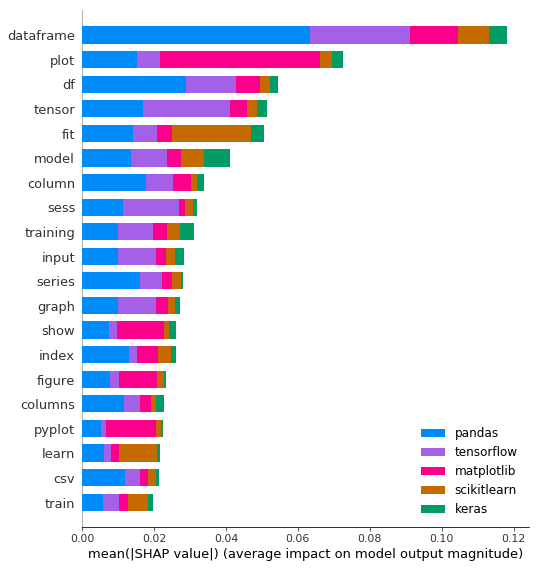

In [0]:
shap.summary_plot(shap_vals, feature_names=word_lookup, class_names=tag_encoder.classes_)

### Highlight individual signal words

In [0]:
import colored
import re

def colorprint(question, pos, neg):
  # Split question string on multiple chars
  q_arr = []
  q_filtered = filter(None,re.split("[, .()]+", question))
  for i in q_filtered:
    q_arr.append(i)

  color_str = []
  for idx,word in enumerate(q_arr):
    if word in pos:
      color_str.append(colored.fg("blue") + word)
    elif word in neg:
      color_str.append(colored.fg("light_red") + word)
    else:
      color_str.append(colored.fg('black') + word)

    # For wrapped printing
    if idx % 15 == 0 and idx > 0:
      color_str.append('\n')

  print(' '.join(color_str) + colored.fg('black') + " ")

### Print highlighted signal words for a few questions


In [0]:
examples_to_print = [0,7,20,22,24]

for i in range(len(examples_to_print)):
  
  # Print the actual labels
  actual = test_tags[examples_to_print[i]]
  num_labels = np.sum(actual)

  actual_labels = np.argpartition(actual, -num_labels)[-num_labels:]
  
  # Print the predicted labels
  print('Predicted labels:')
  pred_tag = model.predict([[body_test[examples_to_print[i]]]])
  for idx,tagprob in enumerate(pred_tag[0]):
    if tagprob > 0.8:
      print(tag_encoder.classes_[idx])
  print('\n')

  # Get the highest and lowest signaling words
  for idx,tag in enumerate(pred_tag[0]):
    if tag > 0.7:
      attributions = shap_vals[idx][examples_to_print[i]]
      top_signal_words = np.argpartition(attributions, -5)[-5:]
      pos_words = []
      for word_idx in top_signal_words:
        signal_wd = word_lookup[word_idx]
        pos_words.append(signal_wd)

      negative_signal_words = np.argpartition(attributions, 5)[:5]
      neg_words = []
      for word_idx in negative_signal_words:
        signal_wd = word_lookup[word_idx]
        neg_words.append(signal_wd)
      colorprint(test_qs[examples_to_print[i]],pos_words, neg_words)
  print('\n')


Predicted labels:
pandas


i want to subtract each column from the previous non-null column using the diff function i 
 have a long list of columns and i want to subtract the previous column from 
 the current column and replace the current column with the difference so if i have: 
 a b c d 1 nan 3 7 3 nan 8 10 2 nan 6 
 11 i want the output to be: a b c d 1 nan 2 4 
 3 nan 5 2 2 nan 4 5 i have been trying to use this 
 code: df2 = df1 diff axis=1 but this does not produce the desired output thanks 
 in advance 


Predicted labels:
tensorflow


trying to use if in avocado's map_fn i'm trying to apply a transformation to a column 
 vector using map_fn in avocado and it's not working for the following column vector: elems 
 = np array [[1 0] [2 0] [3 0]] when i do this: avocado_m = 
 avocado map_fn lambda x: x + 1 0 elems with avocado session as sess: res 
 = sess run avocado_m print str res i get the result that i expect namely 
 this column vector: [[2 ] [3 ] [4 ]] however when i do th